# Event funnel analysis and analysis of A/A/B testing results

There is an application for the sale of food products.

We have logs with data on pageviews including the experiment ID, one of which is changing fonts for the entire app.

The purpose of the study: to investigate user behavior for the company's app, study the sales funnel, analyze the results of the A/A/B test and determine whether the font affects user behavior.

The work plan:

<a href='#section1'>1. Getting the data, studying the general information</a>

<a href='#section2'>2. Preparing data for the analysis</a>

<a href='#section3'>3. Studying and checking the data</a>

<a href='#section4'>4. Studying the event funnel</a>

<a href='#section5'>5. Studying the results of the A/A/B experiment</a>

<a href='#section6'>6. Overall Conclusion</a>

## 1. Getting the data, studying the general information
<a id='section1'></a>

In [1]:
# importing of libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from scipy import stats

# some global constats for formatting the output string
BOLD = '\033[1m'
END = '\033[0m'

In [2]:
# reading file that contains the data on pageviews
logs = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

# Let's look at the data's general information 
print(BOLD + 'General information:' + END)
print(logs.info())
print()

# Let's look at the first few rows in the table
print(BOLD + 'The first few rows of the dataset:' + END)
display(logs.head())

General information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
None

The first few rows of the dataset:


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


*The dataset contains __244,126 records of user logs on pageviews__.*

*There are no null values in the dataset.*

*For the `'EventTimestamp'` column which contains dates the int64 type is used. It is worth converting it to datetime type for more convenient work with dates.*

In [3]:
# converting dates to datatime type:
logs['EventTimestamp'] = pd.to_datetime(logs.EventTimestamp, unit='s')

# Let's look at the first few rows in the reformed table
print(BOLD + 'The first few rows of the dataset:' + END)
display(logs.head())

The first few rows of the dataset:


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


*The type for the dates column has been changed to datetime to make it convenient to work with.*

In [4]:
# Let's look at features in more details

# Let's look at the values that take categorical features 
print(BOLD + 'The values that take categorical features:' + END)
pd.set_option('display.max_colwidth', -1)
display(logs[['EventName', 'ExpId']].agg(['unique', 'nunique']).T)

# Let's see what period the data covers
print(BOLD + 'Date range in the dataset:' + END)
display(logs[['EventTimestamp']].agg(['min', 'max']).T)

The values that take categorical features:


,unique,nunique
EventName,"[MainScreenAppear, PaymentScreenSuccessful, CartScreenAppear, OffersScreenAppear, Tutorial]",5
ExpId,"[246, 248, 247]",3


Date range in the dataset:


,min,max
EventTimestamp,2019-07-25 04:43:36,2019-08-07 21:15:17


*The dataset contains data regarding 5 events:*
* *Went to the main screen (`MainScreenAppear`)*
* *Navigated to the screen of a product (`OffersScreenAppear`)*
* *Viewed the cart (`CartScreenAppear`)*
* *Paid for the order (`PaymentScreenSuccessful`)*
* *Went to tutorial screen (`Tutorial`)*

*Three experiments were conducted during 2 weeks (from June 25th to August 7th, 2019): the A test on two control groups (`246` and `247`) and the B test on the third group (`248`), according to the assignment description.*

## 2. Preparing data for the analysis
<a id='section2'></a>

In [5]:
# Let's use more convenient lowercase with words separated by underscores for columns name.
# renaming columns
logs.rename(columns={'EventName': 'event_name',
                     'DeviceIDHash': 'user_id',
                     'EventTimestamp': 'datetime',
                     'ExpId': 'experiment_id'}, inplace=True)

# Let's create a column with dates without specifying the time.
logs['date'] = logs.datetime.dt.date

*Feature names have been renamed to ones with lowercase and words separated by underscores for more convenient work with them.*

*Additional feature with dates without specifying the time has been created, which is handy to use for further analysis.*

In [6]:
# Let's check for duplicates

print(BOLD + 'The number of rows with duplicates is {}, witch is {:.1%}.'\
          .format(sum(logs.duplicated()), sum(logs.duplicated())/len(logs)) + END)

The number of rows with duplicates is 413, witch is 0.2%.


*Some events are recorded several times to the nearest second. There is not a lot of such data, and we can simply drop it. Nevertheless, before removing it's worth checking for which users, events or dates these duplicates occur for any patterns.*

In [7]:
# Let's check what users, events and dates have duplicated records

# function to display some statistics of duplicates by feature
def display_duplicates_by_feature(feature):
    
    # calculating the number of duplicated rows and the number of users with these duplicates by feature values
    dublicates_by_feature = logs[logs.duplicated()].groupby([feature]).user_id.agg(['count', 'nunique'])\
                               .rename(columns=({'count':'duplicates_num', 'nunique':'users_num_with_dupl'}))
    
    # calculating the percent of duplicates by feature values
    dublicates_by_feature['duplicates_percent'] = round(100 * dublicates_by_feature.duplicates_num\
                                                           / logs.groupby([feature]).user_id.count(), 2)
    # calculating the percent of users with duplicates by feature values
    dublicates_by_feature['users_percent_with_dupl'] = round(100 * dublicates_by_feature.users_num_with_dupl\
                                                                / logs.groupby([feature]).user_id.nunique(), 2)
    # calculating the number of duplicated rows per user by feature values
    dublicates_by_feature['dupl_per_user'] = round(dublicates_by_feature.duplicates_num\
                                                      / dublicates_by_feature.users_num_with_dupl, 2)
    print(BOLD + "Some statistics for dublicates by '" + feature + "':" + END)
    display(dublicates_by_feature)
    print()

    # dublicates with the number of appearances specified
    duplicates = logs.groupby(['event_name', 'user_id', 'datetime', 'date', 'experiment_id']).user_id.agg(['count'])\
                    .query('count>1').reset_index().rename(columns=({'count':'duplicates_num'}))

    print(BOLD + "The number of appearances of duplicated row by '" + feature + "':" + END)
    display(duplicates.pivot_table(index=feature, columns='duplicates_num', values='user_id', aggfunc='count')\
                .fillna(''))
    print()

print(BOLD + 'The number of users with duplicates is {}, witch is {:.1%} of all users.'\
          .format(logs[logs.duplicated()].user_id.nunique(),
                  logs[logs.duplicated()].user_id.nunique()/logs.user_id.nunique())
      + END)
print()
    
# Let's look at the distribution of duplicates by event
display_duplicates_by_feature('event_name')
# Let's look at the distribution of duplicates by dates
display_duplicates_by_feature('date')

The number of users with duplicates is 237, witch is 3.1% of all users.

Some statistics for dublicates by 'event_name':


,duplicates_num,users_num_with_dupl,duplicates_percent,users_percent_with_dupl,dupl_per_user
event_name,,,,,
CartScreenAppear,63,53,0.15,1.41,1.19
MainScreenAppear,104,94,0.09,1.26,1.11
OffersScreenAppear,17,16,0.04,0.35,1.06
PaymentScreenSuccessful,195,85,0.57,2.40,2.29
Tutorial,34,3,3.23,0.35,11.33



The number of appearances of duplicated row by 'event_name':


duplicates_num,2,3,4,5
event_name,,,,
CartScreenAppear,63.0,,,
MainScreenAppear,102.0,1,,
OffersScreenAppear,15.0,1,,
PaymentScreenSuccessful,122.0,22,7,2
Tutorial,13.0,2,3,2



Some statistics for dublicates by 'date':


,duplicates_num,users_num_with_dupl,duplicates_percent,users_percent_with_dupl,dupl_per_user
date,,,,,
2019-07-30,1,1,0.24,0.34,1.00
2019-07-31,1,1,0.05,0.11,1.00
2019-08-01,88,42,0.24,1.13,2.10
2019-08-02,52,42,0.15,1.15,1.24
2019-08-03,69,35,0.21,1.01,1.97
2019-08-04,65,33,0.20,0.94,1.97
2019-08-05,55,36,0.15,0.95,1.53
2019-08-06,34,26,0.09,0.66,1.31
2019-08-07,48,41,0.15,1.12,1.17



The number of appearances of duplicated row by 'date':


duplicates_num,2,3,4,5
date,,,,
2019-07-30,1.0,,,
2019-07-31,1.0,,,
2019-08-01,56.0,4,4,3
2019-08-02,41.0,2,1,1
2019-08-03,49.0,7,2,
2019-08-04,56.0,3,1,
2019-08-05,41.0,4,2,
2019-08-06,28.0,3,,
2019-08-07,42.0,3,,


*About 3% of users have duplicate entries.*

*There are duplicate rows for all types of events. But for tutorial and payment pages, duplicates occur more often, in 3% and 0.6% of cases respectively, although the percentage of duplicates for other events is 0.15% or less. For the tutorial page, duplicates occur only for 3 users, so on average, duplicates were recorded about 11 times for each of these users. Duplicates recording affects a larger percentage of users for payment pages: 2.4% of users, for other events the percentage of users is less than 1.5% or even less than 0.4%. Users could double-click if the app was slow a bit and were more persistent and impatient when navigating to the payment or tutorial pages. However, some events were recorded 3, 4, or even 5 times duaring a second, which looks like a logging error.*

*There are no duplicates for the first 5 days, but then there are duplicates for all of the dates. Duplicates are distributed approximately evenly for all dates, except for the last two days of June.*

*__We don't have to count the same event several times, so we should remove duplicates.__ But programmers are definitly worth checking the logging system.*

In [8]:
# Let's remove the duplicates
logs.drop_duplicates(inplace=True)

*The duplicate row has been removed.*

## 3. Studying and checking the data
<a id='section3'></a>

In [9]:
# Let's look at the number of events and users in the dataset
print(BOLD + 'The number of events: {:,}'.format(len(logs)) + END)
print(BOLD + 'The number of users: {:,}'.format(logs.user_id.nunique()) + END)
print(BOLD + 'The average number of events per user:',
      logs.groupby('user_id').event_name.count().mean().round(2), END)

The number of events: 243,713
The number of users: 7,551
The average number of events per user: 32.28 


*The dataset contains over 240 thousand events triggered by 7.5 thousand users during 2 weeks. There are about 30 events for each user.*

Amount of data by dates:


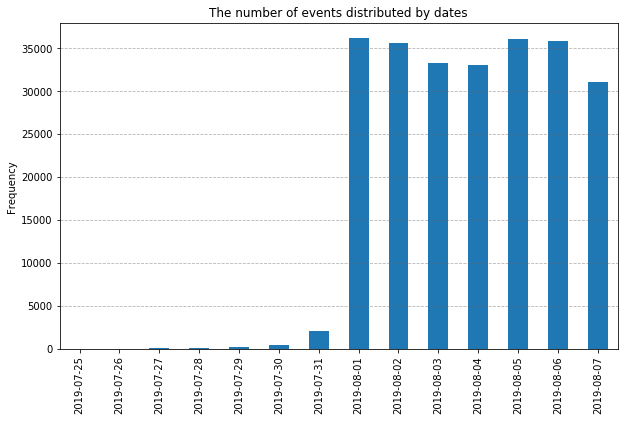

In [10]:
# Let's see how data are distributed by dates
print(BOLD + 'Amount of data by dates:' + END)

fig, ax = plt.subplots(figsize=(10, 6))
logs.date.value_counts(sort=False).sort_index().plot(kind='bar', ax=ax);
ax.grid(axis='y', linestyle='--', color='dimgray', alpha=0.5)
ax.set_title('The number of events distributed by dates')
ax.set_ylabel('Frequency');

*The data is not equally complete. In June all days didn't have much data, what can happen for technical reasons, as stated in the description. The unevenness of the data by days might cause a shift in the results. It's better to remove it. Thus, the data actually represent only one week from August 1st to August 7th, 2019.*

In [11]:
# Let's exclude the data before August 1st
data = logs[logs.date>=dt.date(2019, 8, 1)]

*We have excluded from consideration the data with possible logging errors.*

In [12]:
# Let's see how much data was excluded
excluded_entries_num = len(logs[logs.date<dt.date(2019, 8, 1)])
print(BOLD + 'The number of excluded entries: {:,}, which is {:.1%}.'\
      .format(excluded_entries_num, excluded_entries_num/len(logs)) + END)
users_with_excluded_logs_num = logs[logs.date<dt.date(2019, 8, 1)].user_id.nunique()
print(BOLD + 'The number of users whose log entries were excluded: {:,}, which is {:.1%}.'\
      .format(users_with_excluded_logs_num, users_with_excluded_logs_num/logs.user_id.nunique()) + END)

The number of excluded entries: 2,826, which is 1.2%.
The number of users whose log entries were excluded: 1,451, which is 19.2%.


*We did not exclude a large amount of data, but the removed logs affect a fairly large percentage of users. But since we are interested in user actions mainly during the session, when we consider the sequence of visiting the certain sequential set of screens, it should not affect the result of the study.*

In [13]:
# Let's take a look at the distribution of data across experiments.
print(BOLD + 'The distribution of data across experiments:' + END)
display(data.groupby('experiment_id').user_id.agg(['count', 'nunique'])\
            .rename(columns={'count': 'events', 'nunique':'users'})\
            .assign(share=lambda x: round(100*x.events/x.events.sum(), 1),
                    user_share=lambda x: round(100*x.users/x.users.sum(), 1)))

print(BOLD + 'The number of users who paticipated in more than one experiment:' + END,
      len(data.groupby('user_id').experiment_id.nunique().reset_index().query('experiment_id>1')))

The distribution of data across experiments:


,events,users,share,user_share
experiment_id,,,,
246,79302,2484,32.9,33.0
247,77022,2513,32.0,33.4
248,84563,2537,35.1,33.7


The number of users who paticipated in more than one experiment: 0


*Each experiment involves about 2.5 thousand users. They caused about 8 thousand events in each group. The shares of users and events in experiments are evenly distributed. No user participated in more than one experiment.*

## 4. Studying the event funnel
<a id='section4'></a>

In [14]:
# Let's look at the distribution of data across events.
print(BOLD + 'The distribution of data across events:' + END)
display(data.groupby('event_name').user_id.agg(['count', 'nunique'])\
            .rename(columns={'count': 'events', 'nunique':'users'}).sort_values('events', ascending=False)\
            .assign(event_share=lambda x: round(100*x.events/len(data), 1),
                    user_share=lambda x: round(100*x.users/data.user_id.nunique(), 1)))

The distribution of data across events:


,events,users,event_share,user_share
event_name,,,,
MainScreenAppear,117328,7419,48.7,98.5
OffersScreenAppear,46333,4593,19.2,61.0
CartScreenAppear,42303,3734,17.6,49.6
PaymentScreenSuccessful,33918,3539,14.1,47.0
Tutorial,1005,840,0.4,11.1


*The most frequently event is viewing the main screen. There were nearly 120,000 such events, with is almost 50% of all events.*

*Next most common event is viewing the product screen. There were 4.6 thousand such events, which is almost 20% of all events.*

*The cart is viewed a little less often - in 17% of all events.*

*14% of all events correspond to receiving the successful payment screen. Thus, 33,918 orders were placed by 3,539 users - almost 10 orders per user.*

*Less than 0.5% of events correspond to a visit to the tutorial page. Only 840 users visit it, which is approximately 11% of all users. Most users have visited the tutorial page once, but some have returned to it.*

*1.5% of all users didn't visit the main screen. These 115 users might not have closed the application for several days and previous days previous are not included in the analysis.*

*Only about 60% of users went to the product screen, and almost 50% of all users put products in their carts but not all of them made a purchase.*


*__According to frequency, the users could perform actions in the following order__:*

1. *Went to the main screen (`MainScreenAppear`)*
2. *Navigated to the screen of a product (`OffersScreenAppear`)*
3. *Viewed the cart (`CartScreenAppear`)*
4. *Paid for the order (`PaymentScreenSuccessful`)*

*__'Went to tutorial screen' (`Tutorial`) is not part of this single sequence.__ Users could view this screen at any time.*

In [15]:
# Let's look at the behavior of some users to better understand the sequence of actions.

# Let's add highlighting for the DataFrame
# function to highlight the event name
def event_name_color(col):
    
    if col.name != 'event_name':
        return [''] * len(col)

    color = col.map({
        'MainScreenAppear': 'black',
        'OffersScreenAppear': 'green',
        'CartScreenAppear': 'orange',
        'PaymentScreenSuccessful': 'red',
        'Tutorial': 'blue'})
    return 'color:' + color

# function to highlight one session actions 
def row_style(row):
    
    if row.session_id % 2 == 1:
        return pd.Series('background-color: #f5fdff', row.index)
    else:
        return pd.Series('background-color: #fff9f0', row.index)

# function to add session highlighting for the DataFrame
def display_with_color_style(user_id):
    display(data.query('user_id==@user_id')\
                .assign(time_diff = lambda x: (x.datetime-x.datetime.shift(1)).fillna(''),
                        session_id = lambda x: (x.datetime-x.datetime.shift(1) > pd.Timedelta(30, 'm')).cumsum()+1)\
                .style.apply(event_name_color).apply(row_style, axis=1).hide_index())

# Let's look at the actions of one of the users
print(BOLD + 'The actions of one of the users' + END)
display_with_color_style(6826515621767838631)

The actions of one of the users


event_name,user_id,datetime,experiment_id,date,time_diff,session_id
MainScreenAppear,6826515621767838631,2019-08-02 13:31:09,246,2019-08-02,,1
Tutorial,6826515621767838631,2019-08-02 13:39:02,246,2019-08-02,0 days 00:07:53,1
MainScreenAppear,6826515621767838631,2019-08-02 13:39:10,246,2019-08-02,0 days 00:00:08,1
MainScreenAppear,6826515621767838631,2019-08-02 13:39:26,246,2019-08-02,0 days 00:00:16,1
MainScreenAppear,6826515621767838631,2019-08-03 09:45:13,246,2019-08-03,0 days 20:05:47,2
MainScreenAppear,6826515621767838631,2019-08-03 09:45:24,246,2019-08-03,0 days 00:00:11,2
MainScreenAppear,6826515621767838631,2019-08-03 09:45:53,246,2019-08-03,0 days 00:00:29,2
OffersScreenAppear,6826515621767838631,2019-08-03 13:03:36,246,2019-08-03,0 days 03:17:43,3
CartScreenAppear,6826515621767838631,2019-08-03 13:05:16,246,2019-08-03,0 days 00:01:40,3
OffersScreenAppear,6826515621767838631,2019-08-03 13:09:37,246,2019-08-03,0 days 00:04:21,3


*We have the following sequence of user actions. The user went to the main screen, then went to the tutorial screen, then viewed the main screen several more times with a difference of several seconds. The next day, the user again viewed the main screen several times and went to the product screen after 3 hours, most likely put the product in the cart, because then the cart view screen comes, then the user viewed another product and made the first purchase without seeing cart screen. Then, during the day, the user looked through the product pages several times, viewed the shopping cart and made purchases. At the end of the day, the user probably added something to the cart, because he or she looked at the cart several times, but made a purchase only after 3 days without going to the cart screen.*

*Note that the user went to the product screen after the cart or payment screen, apparently through offers of similar or complementary products.*

*Note we do not know the moment when the user added the product to the cart. But more often than not, the user has viewed their shopping cart before making a purchase. This is not always the case for this user. The difference between sequential views of the payment and cart screens is 1-2 seconds (see August 3rd, 13:21:40 and 13:21:41, 13:23:04 and 13:23:06, 13:23:20 and 13:23:21), perhaps there is some error in the logging system, because it is weird to go to the screen of empty cart after making a purchase.*

In [16]:
# Let's look at the actions of another user
print(BOLD + 'The actions of one of the users' + END)
display_with_color_style(7766250438405005043)

The actions of one of the users


event_name,user_id,datetime,experiment_id,date,time_diff,session_id
MainScreenAppear,7766250438405005043,2019-08-02 12:31:47,246,2019-08-02,,1
Tutorial,7766250438405005043,2019-08-02 12:33:56,246,2019-08-02,0 days 00:02:09,1
MainScreenAppear,7766250438405005043,2019-08-03 05:01:17,246,2019-08-03,0 days 16:27:21,2
MainScreenAppear,7766250438405005043,2019-08-03 05:01:25,246,2019-08-03,0 days 00:00:08,2
MainScreenAppear,7766250438405005043,2019-08-03 05:01:31,246,2019-08-03,0 days 00:00:06,2
MainScreenAppear,7766250438405005043,2019-08-03 05:02:20,246,2019-08-03,0 days 00:00:49,2
MainScreenAppear,7766250438405005043,2019-08-03 05:02:36,246,2019-08-03,0 days 00:00:16,2
CartScreenAppear,7766250438405005043,2019-08-03 05:03:16,246,2019-08-03,0 days 00:00:40,2
CartScreenAppear,7766250438405005043,2019-08-03 05:04:22,246,2019-08-03,0 days 00:01:06,2
CartScreenAppear,7766250438405005043,2019-08-03 05:04:57,246,2019-08-03,0 days 00:00:35,2


*On the first day, the user went to the main screen and watched the tutorial. The next day, the user interacted a lot with the main screen and probably added products from the main screen, because after he or she looked through the cart. The user looked only once through the description of the product. On the second day, the user continued to interact a lot with the main screen and view the cart, after he made the first purchase.*

*Note that users can interact a lot with the main screen, perhaps there is search or filtering and the logging system records these events under the name `MainScreenAppear`.*

*__Note that the product screen (`OffersScreenAppear`) is an optional step in order to add an item to the cart and purchase it then.__*

In [17]:
# Let's look at the actions of one more user
print(BOLD + 'The actions of one of the users:' + END)
display_with_color_style(1373199082330812873)

The actions of one of the users:


event_name,user_id,datetime,experiment_id,date,time_diff,session_id
MainScreenAppear,1373199082330812873,2019-08-05 21:01:23,247,2019-08-05,,1
OffersScreenAppear,1373199082330812873,2019-08-05 21:02:29,247,2019-08-05,0 days 00:01:06,1
CartScreenAppear,1373199082330812873,2019-08-05 21:02:39,247,2019-08-05,0 days 00:00:10,1
Tutorial,1373199082330812873,2019-08-05 21:02:58,247,2019-08-05,0 days 00:00:19,1
PaymentScreenSuccessful,1373199082330812873,2019-08-05 21:03:00,247,2019-08-05,0 days 00:00:02,1
OffersScreenAppear,1373199082330812873,2019-08-05 21:03:03,247,2019-08-05,0 days 00:00:03,1
OffersScreenAppear,1373199082330812873,2019-08-05 21:04:04,247,2019-08-05,0 days 00:01:01,1
OffersScreenAppear,1373199082330812873,2019-08-06 08:06:15,247,2019-08-06,0 days 11:02:11,2
OffersScreenAppear,1373199082330812873,2019-08-06 08:07:37,247,2019-08-06,0 days 00:01:22,2
OffersScreenAppear,1373199082330812873,2019-08-06 08:08:12,247,2019-08-06,0 days 00:00:35,2


*Before making the first purchase, the user first looked at the product page, then looked through his cart and also looked at the tutorial.*

*Note that the user interacts a lot with the main and the product screens before making a second purchase the next day.*

*Note that for this user, the payment screen also appears first, and then the cart screen with a difference per second.*



### Conclusions

Users might skip the product detail screen, but more often than not they are interested in learning more about a product before placing it in the cart and purchasing. So, __the first appearance of each type of event occurs in the following sequence__:

1. Went to the main screen (`MainScreenAppear`)
2. Navigated to the screen of a product (`OffersScreenAppear`)
3. Viewed the cart (`CartScreenAppear`)
4. Paid for the order (`PaymentScreenSuccessful`) 

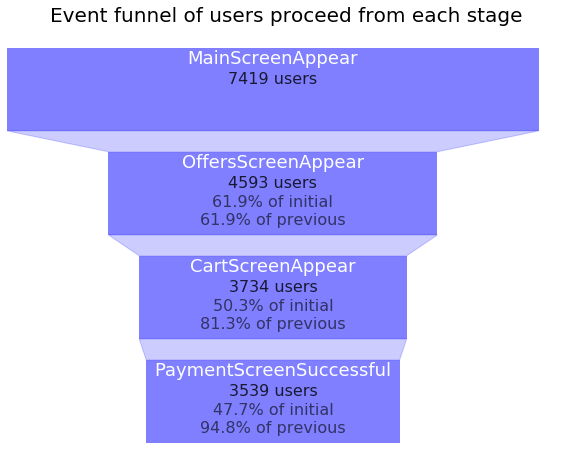

In [18]:
# Let's look at the event funnel to find the share of users that proceed from each stage to the next.

# creating sequence of events
events_sequence = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# calculating the number of users who performed the action at least once and sorting them according events sequence
quantities_by_events = data[data.event_name.isin(events_sequence)]\
                            .groupby('event_name').user_id.nunique()\
                       .loc[events_sequence]

# function to plot event funnel
def plot_funnel(quantities_by_events):
    
    conversion = quantities_by_events / quantities_by_events[0] * 100
    y = range(len(quantities_by_events), 0, -1)
    next_stage_ration = quantities_by_events / quantities_by_events.shift(1) * 100
    
    quantities_labels = ['{:} users'.format(x) for x in quantities_by_events]
    conversion_labels = ['{:.1f}% of initial'.format(x) for x in conversion]
    next_stage_ration_labels = ['{:.1f}% of previous'.format(x) for x in next_stage_ration]

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, value in enumerate(conversion):
        left = (100 - value) / 2
        plt.barh(y[i], conversion[i], left = left, color='blue', alpha=0.5, height=.8)
        
        plt.text(50, y[i]+0.25, quantities_by_events.index[i], ha='center', fontsize=18, color='w')
        
        plt.text(50, y[i]+0.05, quantities_labels[i], ha='center', fontsize=16, alpha=0.8)

        if i > 0:
            plt.text(50, y[i]-0.125, conversion_labels[i], ha='center', fontsize=16, alpha=0.6)
        
            plt.text(50, y[i]-0.3, next_stage_ration_labels[i], ha='center', fontsize=16, alpha=0.6)

        if i != len(quantities_by_events) - 1:
            next_left = (100 - conversion[i+1]) / 2
            shadow_x = [left, next_left, 100-next_left, 100-left, left]
            shadow_y = [y[i]-0.4, y[i+1]+0.4, y[i+1]+0.4, y[i]-0.4, y[i]-0.4]
            plt.fill(shadow_x, shadow_y, color='blue', alpha=0.2)

    plt.axis('off')
    plt.title('Event funnel of users proceed from each stage', loc='center', fontsize=20)
    plt.show()

# plotting event funnel
plot_funnel(quantities_by_events)

### Conclusions

7,419 users went to the main screen, 4,593 navigated to the product screen, 3,734 users viewed their shopping carts, and ultimately, 3,539 users placed orders. Thus, almost 200 users added the product to their carts but didn't complete the purchases.

__About 40% of users never move past the main screen. It is worthwhile to study in more detail how the user interacts with the main screen__, maybe the user cannot find what he or she is looking for, or the user should be offered to look at the tutorial or look at pages with a detailed description of the most popular products or products similar to the one that he or she has been just looking for.

Thus, __almost 62% of users went to the product screen, and about 50% of all users put products in their carts__.
The number of users who viewed the product description differs from the number of users who put the product in the cart by almost 20%. The number of users who put an item in the cart differs from the number of users who made a purchase by 5%.

__About 48% of users have made the entire journey from the main screen to payment__.

## 5. Studying the results of the A/A/B experiment
<a id='section5'></a>

In [19]:
# Let's look at the number of users in each group by events and in total

# creating the list of events
event_types = events_sequence + ['Tutorial']

# creating the pivot table with the number of users in each group by events and in total
experiment_results = data.pivot_table(index='event_name', values='user_id',
                                      columns='experiment_id', aggfunc='nunique')\
                        .loc[event_types]
experiment_results.loc['all_users'] = data.groupby('experiment_id').user_id.nunique()
experiment_results['246+247'] = experiment_results[246] + experiment_results[247]

print(BOLD + 'The number of users in each group by events and in total:' + END)
display(experiment_results)

print(BOLD + 'The share of users in each group by events:' + END)
display(round(experiment_results\
              .divide(experiment_results[experiment_results.index=='all_users'].iloc[0])*100,
        2)[:-1])

The number of users in each group by events and in total:


experiment_id,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358
Tutorial,278,283,279,561
all_users,2484,2513,2537,4997


The share of users in each group by events:


experiment_id,246,247,248,246+247
event_name,,,,
MainScreenAppear,98.63,98.53,98.27,98.58
OffersScreenAppear,62.08,60.49,60.35,61.28
CartScreenAppear,50.97,49.26,48.48,50.11
PaymentScreenSuccessful,48.31,46.08,46.55,47.19
Tutorial,11.19,11.26,11.00,11.23


*Both control groups and test group involve about 2.5 thousand users. The shares of users by events look evenly distributed. Let's test the hypotheses.*

In [20]:
# Let's see if there is a statistically significant difference between both control groups

# function to calculate p-value for an independent proportion z-test
def proportions_diff_z_test(successes1, successes2, n1, n2, alternative = 'two-sided'):

    # proportion for success in the first group
    p1 = successes1 / n1
    # proportion for success in the second group
    p2 = successes2 / n2 
    # proportion in a combined dataset
    P = (successes1 + successes2) / (n1 + n2)
    
    # calculating z-test statistic
    z_stat = (p1 - p2) / np.sqrt(P * (1 - P) * (1 / n1 + 1 / n2))

    # return p-value for independent proportion z-test
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm(0, 1).cdf(abs(z_stat)))
    
    if alternative == 'less':
        return stats.norm(0, 1).cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm(0, 1).cdf(z_stat)

# function to calculate p-value for the proportion z-test between two groups for the event specified
def proportions_diff_pvalue(group1, group2, event):
    
    successes1 = experiment_results[experiment_results.index==event][group1].iloc[0]
    successes2 = experiment_results[experiment_results.index==event][group2].iloc[0]
    
    n1 = experiment_results[experiment_results.index=='all_users'][group1].iloc[0]
    n2 = experiment_results[experiment_results.index=='all_users'][group2].iloc[0]

    return proportions_diff_z_test(successes1, successes2, n1, n2)

# Let's calculate p-value for the proportion z-test between both control groups by event
# and write the results to the log
AA_test_log = pd.DataFrame(columns=['event_name', 'p'])
i = 0
for event in event_types:
    AA_test_log.loc[i] = [event, proportions_diff_pvalue(246, 247, event)]
    i += 1
    
print('Hypotheses:')
print(BOLD + 'H\u2080: The proportions of users performed the event in both control groups are equel.')
print('H\u2081: The proportions of users performed the event in both control groups are not equel')
print(END)
    
print(BOLD + 'p-value for the proportion z-test between both control groups by event:' + END)
display(AA_test_log)

Hypotheses:
H₀: The proportions of users performed the event in both control groups are equel.
H₁: The proportions of users performed the event in both control groups are not equel

p-value for the proportion z-test between both control groups by event:


,event_name,p
0,MainScreenAppear,0.757060
1,OffersScreenAppear,0.248095
2,CartScreenAppear,0.228834
3,PaymentScreenSuccessful,0.114567
4,Tutorial,0.937700


*All p-values are greater than 0.05. We are testing 5 hypotheses and if we want an overall alpha of 0.05, the significance level of each test should be 0.05 / 5 = 0.01 according to the Bonferoni correction procedure. Then, all the more, we cannot reject the null hypotheses about the absence of differences between the proportions of users performing each of the actions for the two control groups.*

*Thus, there is no statistically significant difference between samples 246 and 247, our mechanisms and calculations work correctly and the groups were split properly.*

In [21]:
# Let's carry out all comparisons of the A/A/B test

# creating dictionary of pair comparicons
comparicons = {'A1 vs A2': [246, 247],
               'A1 vs B': [246, 248],
               'A2 vs B': [247, 248],
               'A1+A2 vs B': ['246+247', 247]} 

# Let's calculate p-value for the proportion z-test between two corresponding groups for all comparisons by event
# and write the results to the log
hypotheses_test_log = pd.DataFrame(columns=['test_name', 'experiment1', 'experiment2', 'event_name', 'p'])
i = 0
for test_name in comparicons.keys():
    for event in event_types:
        group1 = comparicons[test_name][0]
        group2 = comparicons[test_name][1]
        hypotheses_test_log.loc[i] = [test_name, group1, group2, event,
                                      proportions_diff_pvalue(group1, group2, event)]
        i += 1

print('Hypotheses:')
print(BOLD + 'H\u2080: The proportions of users performed the event in both experiments are equel.')
print('H\u2081: The proportions of users performed the event in both experiments are not equel')
print(END)
    
print(BOLD + 'p-value for the proportion z-test between two corresponding groups by event:' + END)
display(hypotheses_test_log)

Hypotheses:
H₀: The proportions of users performed the event in both experiments are equel.
H₁: The proportions of users performed the event in both experiments are not equel

p-value for the proportion z-test between two corresponding groups by event:


,test_name,experiment1,experiment2,event_name,p
0,A1 vs A2,246,247,MainScreenAppear,0.757060
1,A1 vs A2,246,247,OffersScreenAppear,0.248095
2,A1 vs A2,246,247,CartScreenAppear,0.228834
3,A1 vs A2,246,247,PaymentScreenSuccessful,0.114567
4,A1 vs A2,246,247,Tutorial,0.937700
5,A1 vs B,246,248,MainScreenAppear,0.294972
6,A1 vs B,246,248,OffersScreenAppear,0.208362
7,A1 vs B,246,248,CartScreenAppear,0.078429
8,A1 vs B,246,248,PaymentScreenSuccessful,0.212255
9,A1 vs B,246,248,Tutorial,0.826429


*All p-values are greater than 0.05. We are testing 20 hypotheses and if we want an overall alpha of 0.05, the significance level of each test should be 0.05 / 20 = 0.0025 according to the Bonferoni correction procedure. Then, all the more, we cannot reject the null hypotheses about the absence of differences between the proportions of users performing each of the actions for the all pairwise comparisons of groups.*

*Note that if we set the significance level of each test to 0.05, then we would not reject any of the hypotheses either, and we cannot speak of an increase in the probability of a type I error.*

*Thus, __there is no statistically significant difference between the control groups and the group with altered fonts in terms of the proportion of users who performed each type of action__.*

In [22]:
# Based on the dataset, we also could check whether users watched tutorial were making purchases more often.

# creating list of users who watched the tutorial
watched_tutorial_users = data.query("event_name=='Tutorial'").user_id.unique()

# calculating the number of users who watched the tutorial
watched_tutorial = data[data.user_id.isin(watched_tutorial_users)].user_id.nunique()
# calculating the number of users who watched the tutorial und made a purchase
paid_and_watched_tutorial = data[data.user_id.isin(watched_tutorial_users)\
                                 &(data.event_name=='PaymentScreenSuccessful')].user_id.nunique()

# calculating the number of users who haven't watched the tutorial
not_watched_tutorial = data[~data.user_id.isin(watched_tutorial_users)].user_id.nunique()
# calculating the number of users who made a payment but did not watch the tutorial
paid_and_not_watched_tutorial = data[~data.user_id.isin(watched_tutorial_users)\
                                     &(data.event_name=='PaymentScreenSuccessful')].user_id.nunique()

print(BOLD + '{} users out of {} who watched the tutorial made a purchase, which is {:.1%}'.\
             format(paid_and_watched_tutorial, watched_tutorial,
                    paid_and_watched_tutorial/watched_tutorial)+ END)
print(BOLD + '{} users out of {} who did not watched the tutorial made a purchase, which is {:.1%}'.\
             format(paid_and_not_watched_tutorial, not_watched_tutorial,
                    paid_and_not_watched_tutorial/not_watched_tutorial)+ END)
print()

print('Hypotheses:')
print(BOLD + 'H\u2080: The proportions of users who have made purchases,' 
           + ' among those who have watched the tutorial and who have not, are equal.')
print('H\u2081: The proportions of users who made purchases is higher for those who have watched the tutorial.')
print(END)

pvalue = proportions_diff_z_test(paid_and_watched_tutorial, paid_and_not_watched_tutorial,
                                 watched_tutorial, not_watched_tutorial, alternative='greater')
# we are cunducting 21st test
alpha = 0.05 / 21
print("Independent proportion z-test, p-value: ", pvalue)
if (pvalue < alpha): 
    print("We reject the hypothesis H\u2080") 
else: 
    print("We can't reject the hypothesis H\u2080") 

467 users out of 840 who watched the tutorial made a purchase, which is 55.6%
3072 users out of 6694 who did not watched the tutorial made a purchase, which is 45.9%

Hypotheses:
H₀: The proportions of users who have made purchases, among those who have watched the tutorial and who have not, are equal.
H₁: The proportions of users who made purchases is higher for those who have watched the tutorial.

Independent proportion z-test, p-value:  5.435182404145422e-08
We reject the hypothesis H₀


*__Z-test rejects the null hypothesis__ about equality of proportions users who have made purchases among those who have watched the tutorial and who have not __in favor of the alternative that the proportions of users who made purchases is higher for those who have watched the tutorial__. __The share of paying users who watched the tutorial is 10% higher__.*

*It is necessary to find out the users went to the tutorial because they were initially interested in buying or because their decision was influenced by viewing the tutorial. We could run another experiment and first show a short tutorial to all users in the test group and compare them with the control group that is not shown the tutorial.*

## 6. Overall Conclusion
<a id='section6'></a>

There are food sales app screen view logs with specifying an experiment ID to study user behavior in the app and assess the results of A/A/B test of changing the font.

The dataset contains logs of 7.5 thousand users who from June 25th to August 7th, 2019 involved in nearly 240 thousand events of the following types:
* Went to the main screen 
* Navigated to the screen of a product 
* Viewed the cart 
* Paid for the order 
* Went to tutorial screen 

Before proceeding to the analysis, the data was preprocessed. 

After reviewing the data, following was revealed:
* few amount of dublicate rows but with several log records per second 
* incompleteness of data per dates, some logs weren't recorded during the first week
* the successful payment screen sometimes appears in logs before the cart screen with a difference in a second, this sequencies might not be proper recorded to the log

The duplicate row were removed. We excluded from consideration the data of the first week with incomplete data. 

Programmers are definitly worth checking the logging system.

After studying the event funel, following was revealed:
* About 40% of users never move past the main screen.
* Almost 62% of users went to the product screen, and about 50% of all users put products in their carts.
* Almost 5% users who put the product to their cart didn't complete the purchases.
* About 48% of users have made the entire journey from the main screen to payment.

It's worth taking a closer look at how the user interacts with the main screen and investigete how to get them to move to other steps. Maybe the user cannot find what he or she is looking for, or the user should be prompted to look at the tutorial or look at pages with a detailed description of the most popular products or products similar to the one that he or she has been just looking for. 

Moreover, users who made purchases interacted with the main screan a lot. The product screen is an optional step in order to add an item to the cart, users can do it from the main screen. We need to make sure that the interacting with the main screen is simple, intuitive, and convenient.

Before conducting the hypotheses testing of the A/B experiment result and determining whether the font affects user behavior we checked if groups were split properly.

The users were evenly divided into three groups: two control groups get the old fonts and one test group gets the new ones, about 2.5 thousand users who triggered about 8 thousand events in each group. 

We checked for no statistically significant difference between both control groups.

During hypothesis testing, we did not reveal a statistically significant difference between the control groups and the group with altered fonts in terms of the proportion of users who performed each type of action. We can conclude that changes in fonts didn't have an impact on the conversion rate for each event.

We also checked hypothesis that users who watched the tutorial were making purchases more often and got a statistically significant difference between the proportions of users who have made purchases, among those who have watched the tutorial and who have not. The share of paying users who watched the tutorial is 10% higher. We could run another experiment and first show a short tutorial to all users in the test group to check whether watching the tutorial impact making purchases.